#Project 1 Final
 - Aisling Gilder
 - 05/25/2022

## Imports and setups

In [506]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import plot_tree
from sklearn import set_config
set_config(display='diagram')

In [507]:
#Regression Metrics Function
def evaluate_regression(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'scores: \nMAE: {mae:.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')

In [508]:
#Load dataset
path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTc1PmylYLKD3rktSrJLW6eqxF_yVHHJ-TJnY8qZ2qd8pVeQHBsCtRCd8HLmcT_33DrWC8gl_UMWkYL/pub?output=csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Dataframe Investigation

In [509]:
#check .info to detect data types and see what data is missing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


> Certain columns will not be usefle to out model. Item_Weight is missing nearing 18% of it's data. Any imputations will add too much innacurate data to be meaningut. As such, we will drop it. The Outlet_Size column is missing even more data, 29%, and will also be dropped. How long you have been in business doesn't really have much, if any, bearing on acutal sales now or in the future. Let's investigate some of the other columns for unique or ill defined data.

In [510]:
#Outlet_Establishment_Year is a nominal catagorical column, not an intiger.
#convert the datatype
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), object(8)
memory usage: 799.2+ KB


In [511]:
#First, let's look at 
df['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

>This column is mostly unique ID code type data. It will be dropped.

In [512]:
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

>Again, we see ID number style data. We could be able to use these ID numbers if there was a data dictionary that explained with they correalated to, but we do not have that information at this time. As such, this column will be dropped.

In [513]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

>Looks like we need to clean up the string names in this column before it can be used to model

In [514]:
# Standardize the catagores to Low Fat and Regular only
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [515]:
#drop columns to create new df
df = df.drop(columns=(['Item_Identifier', 'Item_Weight', 'Outlet_Size']))
df.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1,3735.1380
1,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Tier 3,Supermarket Type2,443.4228
2,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Tier 1,Supermarket Type1,2097.2700
3,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Tier 3,Grocery Store,732.3800
4,Low Fat,0.000000,Household,53.8614,OUT013,1987,Tier 3,Supermarket Type1,994.7052


In [516]:
#Check for possible outliers
df.describe()

,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000
mean,0.066132,140.992782,2181.288914
std,0.051598,62.275067,1706.499616
min,0.000000,31.290000,33.290000
25%,0.026989,93.826500,834.247400
50%,0.053931,143.012800,1794.331000
75%,0.094585,185.643700,3101.296400
max,0.328391,266.888400,13086.964800


> We can see that there are some very high outliers in the Item_Outlet_Sales column. While we will be leaving them in for this model, as it is a first pass and the outliers do representing the highest earning locations; they could be removed to allow for a narrow data range to better understand how the bulk of the locations can improve with the model.

## Data Visualization

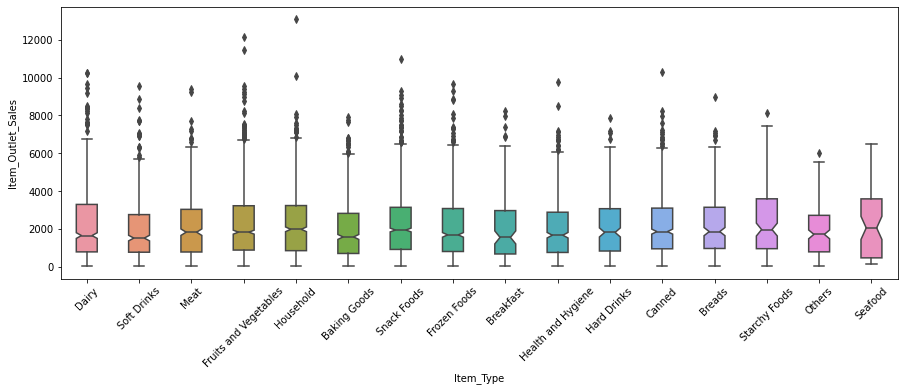

In [540]:
#Boxplot of outlet sales by item types
plt.figure(figsize = (15,5))
sns.boxplot(x = 'Item_Type', y='Item_Outlet_Sales', data=df, width = 0.4, showfliers=True, notch = True)
plt.xticks(rotation=45)
plt.savefig('itemsales.png', bbox_inches = 'tight')

> Diary & Starchy foods have the highest maximum. They are also biased low, indecating higher prices overall and looks like a good item category to focus on. Baked goods, for the additional cost in labor, generate relatily lower mean sales vs the other categories

In [518]:
#Distibution of outlet sale by outlet type
def otype_dist(data,x='Item_Outlet_Sales',figsize=(10,5)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(data=df,x=x,ax=ax,hue='Outlet_Type')
    ax.set_title('Distribution of Outlet Sales');
    return fig,ax

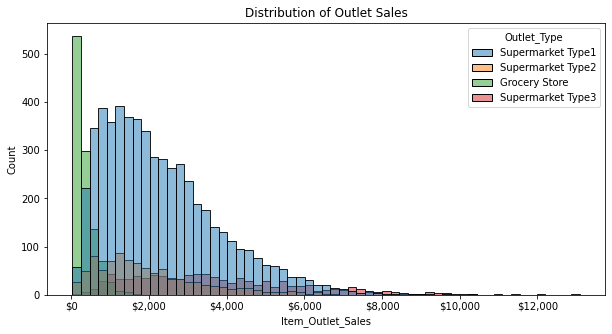

In [538]:
sales_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
fig, ax = otype_dist(df)
ax.xaxis.set_major_formatter(sales_fmt)
fig.savefig('Dist of Sales.png')

>Supermarket Type 2 form the bulk of the sales volume. Any increases to sales for this category would have a larger inpact on total sales. Grocery Store has the lowest overall sales, so implenting model-based strageties here would shift the sales distrubion curve to the right.

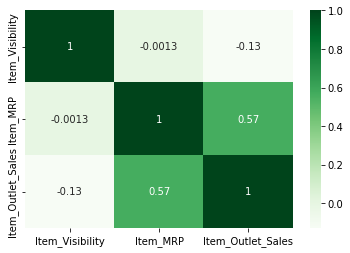

In [537]:
#lets see of a correlation heatmap tells us anything
corr = df.corr()
sns_plot = sns.heatmap(corr, cmap = 'Greens', annot = True)
plt.savefig('corrmap.png')

# New Section

>From the numeric data alone, there is only a moderate correclation between Item_MRP and Item_Outlet_Sales. This is intuitive, as selling items for a higher price should lead to increase sales. 

## Modeling

In [521]:
# As we have already dropped columns in the steps above, we will be adding 'Item_Outlet_Sales' to y and the rest to 'X'
X = df.drop(columns='Item_Outlet_Sales')
y = df['Item_Outlet_Sales']

In [522]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [523]:
#Preprocessing tools
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')
ohe = OneHotEncoder(sparse=True, handle_unknown = 'ignore')
scaler = StandardScaler()

In [524]:
#Create tuples for the preprocessor pipeline
cat_pipe = (ohe, cat_selector)
num_pipe = (scaler, num_selector)
preprocessor = make_column_transformer(num_pipe, cat_pipe)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5244769290>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5244769710>)])

### Decision Tree

In [525]:
#instantiate decision tree model
sales_tree = DecisionTreeRegressor(max_depth=None, random_state = 42)
sales_tree_pipe = make_pipeline(preprocessor, sales_tree)
sales_tree_pipe.fit(X_train, y_train)
print('Train')
evaluate_regression(y_train, sales_tree_pipe.predict(X_train))
print('\nTest')
evaluate_regression(y_test, sales_tree_pipe.predict(X_test))

Train
scores: 
MAE: 0.00 
MSE: 0.00 
RMSE: 0.00 
R2: 1.00

Test
scores: 
MAE: 1028.39 
MSE: 2,180,742.47 
RMSE: 1,476.73 
R2: 0.21


In [526]:
sales_tree.get_depth()

39

>The base decision tree model is overfit to the training data and is not working well on the test data. It will need to be tuned to find the right balance.

In [527]:
#create dataframe to store r^2 scores
scores = pd.DataFrame(columns = ['Train', 'Test'], index = depths)
#Set range to run the for loop for all depths
depths = range(1,40)
#Setup loops
for depth in depths:
  #new model for all depths and fit, with preprocessor, 
  sales = DecisionTreeRegressor(max_depth=depth)
  sales_pipe = make_pipeline(preprocessor, sales)
  sales_pipe.fit(X_train, y_train)
  train_pred = sales_pipe.predict(X_train)
  test_pred = sales_pipe.predict(X_test)
  train_r2 = r2_score(y_train, train_pred)
  test_r2 = r2_score(y_test, test_pred)
  scores.loc[depth, 'Train'] = train_r2
  scores.loc[depth, 'Test'] = test_r2
  

In [528]:
scores.sort_values(by = 'Test', ascending = False)
scores.head()

,Train,Test
1,0.237797,0.229683
2,0.431641,0.433778
3,0.524218,0.524222
4,0.582625,0.584005
5,0.603925,0.594747


In [529]:
optimal_depth = scores.sort_values(by='Test', ascending=False).index[0]
print(optimal_depth)

5


In [530]:
optimal_sales_tree = DecisionTreeRegressor(max_depth = optimal_depth, random_state = 42)
optimal_sales_pipe = make_pipeline(preprocessor, optimal_sales_tree)
optimal_sales_pipe.fit(X_train, y_train)
print('Train')
evaluate_regression(y_train, optimal_sales_pipe.predict(X_train))
print('\nTest')
evaluate_regression(y_test, optimal_sales_pipe.predict(X_test))

Train
scores: 
MAE: 762.58 
MSE: 1,172,164.97 
RMSE: 1,082.67 
R2: 0.60

Test
scores: 
MAE: 738.34 
MSE: 1,118,083.68 
RMSE: 1,057.39 
R2: 0.59


> While tuning our Decision Tree Regression model imporoved the R2 performance on the test data by a wide margin, the mean error metrics saw the greatest improvement, indicating this tuned model has a good fit over the overfit model at the start.

### Randon Forest

In [531]:
rf = RandomForestRegressor(random_state = 42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)
print('RFTrain')
evaluate_regression(y_train, rf_pipe.predict(X_train))
print('\nRFTest')
evaluate_regression(y_test, rf_pipe.predict(X_test))

RFTrain
scores: 
MAE: 296.13 
MSE: 182,883.03 
RMSE: 427.65 
R2: 0.94

RFTest
scores: 
MAE: 763.61 
MSE: 1,205,804.91 
RMSE: 1,098.09 
R2: 0.56


>The inital random forest is giving us similar modeling performance on the test data as the tuned decision tree. Let's see how we can improve this.

In [532]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

depths = range(1, max(est_depths))
rf_scores = pd.DataFrame(index=depths, columns=['RFTest'])
for depth in depths:
  rf_tune = RandomForestRegressor(max_depth=depth, random_state = 42)
  rf_tune_pipe = make_pipeline(preprocessor, rf_tune)
  rf_tune_pipe.fit(X_train, y_train)
  rf_scores.loc[depth, 'RFTrain'] = rf_tune_pipe.score(X_train, y_train)
  rf_scores.loc[depth, 'RFTest'] = rf_tune_pipe.score(X_test, y_test)

In [533]:
sorted_scores = rf_scores.sort_values(by='RFTest', ascending=False)
sorted_scores.head()

,RFTest,RFTrain
5,0.602717,0.610534
6,0.601448,0.623954
7,0.598618,0.642222
8,0.597482,0.664687
4,0.596629,0.595918


In [534]:
optimum_rf = RandomForestRegressor(random_state = 42, max_depth = 5)
optimum_rf_pipe = make_pipeline(preprocessor, optimum_rf)
optimum_rf_pipe.fit(X_train, y_train)
print('RFTrain')
evaluate_regression(y_train, optimum_rf_pipe.predict(X_train))
print('\nRFTest')
evaluate_regression(y_test, optimum_rf_pipe.predict(X_test))

RFTrain
scores: 
MAE: 755.42 
MSE: 1,152,608.49 
RMSE: 1,073.60 
R2: 0.61

RFTest
scores: 
MAE: 728.45 
MSE: 1,096,095.77 
RMSE: 1,046.95 
R2: 0.60


### Model Comparison

In [535]:
print('Train')
evaluate_regression(y_train, optimal_sales_pipe.predict(X_train))
print('\nTest')
evaluate_regression(y_test, optimal_sales_pipe.predict(X_test))
print('\nRFTrain')
evaluate_regression(y_train, optimum_rf_pipe.predict(X_train))
print('\nRFTest')
evaluate_regression(y_test, optimum_rf_pipe.predict(X_test))

Train
scores: 
MAE: 762.58 
MSE: 1,172,164.97 
RMSE: 1,082.67 
R2: 0.60

Test
scores: 
MAE: 738.34 
MSE: 1,118,083.68 
RMSE: 1,057.39 
R2: 0.59

RFTrain
scores: 
MAE: 755.42 
MSE: 1,152,608.49 
RMSE: 1,073.60 
R2: 0.61

RFTest
scores: 
MAE: 728.45 
MSE: 1,096,095.77 
RMSE: 1,046.95 
R2: 0.60
